# Gridworld
In this notebook, we repeatedly solve a simple environment to explore the characteristics of the following algorithm classes, {**Linear Programming (LP)**, **Dynamic Programming (DP)**, **Monte Carlo (MC)**, and **Temporal Difference Learning (TD)**}. For **MC** and **TD**, we also explore further problem spaces in **Prediction**, **On-Policy Control**, and **Off-Policy Control**. We also examine a generalization of **TD**, **N-Step TD**.

From [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html) Example 3.5/3.8 and Berkeley [CS287: Advanced Robotics](https://people.eecs.berkeley.edu/~pabbeel/cs287-fa12/slides/mdps-exact-methods.pdf) (see slide 30)

<img src="images/gridworld.png" width="85%" />

In [1]:
from __future__ import print_function
from IPython.display import display, clear_output
from datetime import datetime, timedelta
from itertools import product
from pandas.plotting import register_matplotlib_converters

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf


pd.options.display.max_columns = None
register_matplotlib_converters()


%matplotlib inline

In [2]:
assert tf.__version__.startswith('2'), tf.__version__

In [3]:
%pip install ortools

from ortools.linear_solver import pywraplp

# need to restart notebook after installing first time
_ = pywraplp.Solver('LinearProgrammingGridworld', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

Looking in indexes: https://pypi.org/simple, https://pypi.lyft.net/pypi/
     |████████████████████████████████| 28.9 MB 17.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


<img src="images/gridworld2.png" width="85%" />

## The Grid
A digital [frontier](https://www.youtube.com/watch?v=4-J4duzP8Ng)...

In [4]:
# optimal strategy, gamma=0.9
expected_values = np.array([
    [22.0, 24.4, 22.0, 19.4, 17.5],
    [19.8, 22.0, 19.8, 17.8, 16.0],
    [17.8, 19.8, 17.8, 16.0, 14.4],
    [16.0, 17.8, 16.0, 14.4, 13.0],
    [14.4, 16.0, 14.4, 13.0, 11.7]
])

## Actions
[North](https://www.youtube.com/watch?v=K31sJIbv_20), [East](https://www.youtube.com/watch?v=dq3rVbGCijo), [West](https://www.youtube.com/watch?v=2LVLo61M0rY), [South](https://www.youtube.com/watch?v=zRYQJw_pYgY)

In [5]:
from enum import Enum


class Action(Enum):
    NORTH = 'N', 0, lambda x: (x[0] - 1, x[1]), (0, 1)
    EAST = 'E', 1, lambda x: (x[0], x[1] + 1), (1, 0)
    WEST = 'W', 2, lambda x: (x[0], x[1] - 1), (-1, 0)
    SOUTH = 'S', 3, lambda x: (x[0] + 1, x[1]), (0, -1)
    def __init__(self, display_name, index, transition, direction):
        self.display_name = display_name
        self.index = index
        self.transition = transition  # numpy row-major coordinates
        self.direction = direction  # matplotlib coordinates
        
    def __str__(self):
        return self.display_name

## Agents

In [6]:
class Agent(object):
    def __init__(self, name):
        self.name = name
        
    def policy(self, state):
        """Return an Action given STATE"""
        raise NotImplementedError()


In [7]:
class GreedyAgent(Agent):
    """
    This agent has perfect information regarding the environment transition probabilities and rewards.
    
    This approach is infeasible for complex problems where the environment is unknown.
    """
    def __init__(self, state_values=None, name='Optimal', gamma=0.9):
        super().__init__(name)
        if state_values is None:
            state_values = np.random.randn(5, 5)
        self.state_values = state_values  # v(s)
        self.gamma = gamma
        
        self.environment = Gridworld()
        
    def policy(self, state):
        """Policy iteration using the exact transition/reward outcomes."""
        action = None
        max_action_value = -1000
        for a in Action:
            self.environment.set_state(state)
            s1, r = self.environment.transition(a)
            
            action_value = r + self.gamma * self.state_values[s1]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value
                
        return action

In [8]:
class EpsilonGreedyAgent(GreedyAgent):
    """
    GreedyAgent with epsilon greedy exploration.
    
    This approach is infeasible for complex problems where the environment is unknown.
    """
    def __init__(self, epsilon=1e-2, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        
    def policy(self, state):
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])
                
        return super().policy(state)

In [9]:
class LearnedAgent(Agent):
    """Learn the Optimal Policy beginning with a random policy and no priors."""    
    def __init__(self, name='Learned', gamma=0.9, dim=5, epsilon=0):
        super().__init__(name)
        self.action_values = np.random.randn(5, 5, 4)  # q(s, a)
        self._policy = {s: random.choice([a for a in Action])
                        for s in product(range(dim), range(dim))}
        self.gamma = gamma
        self.epsilon = epsilon
        
    def policy(self, state):
        if random.random() < self.epsilon:
            return random.choice([a for a in Action])
        return self._policy[state]
    
    def update_state_policy(self, s):
        old_action = self._policy[s]
        stable = True
        max_action_value = -1000
        for a in Action:
            action_value = self.action_values[(s[0], s[1], a.index)]
            if action_value > max_action_value:
                action = a
                max_action_value = action_value
        if action != old_action:
            policy_stable = False
        self._policy[s] = action
        return stable        
    
    def policy_improvement(self):
        """Update our policy based on our latest action_values"""
        policy_stable = True
        for s in self._policy.keys():
            stable = self.update_state_policy(s)
            if not stable:
                policy_stable = False
            
        return policy_stable

## Environment

In [10]:
class Gridworld(object):
    def __init__(self, initial_state=(0, 0)):
        self.dim = 5
        self.state = initial_state
        
    def set_state(self, state):
        self.state = state

    def _transition_state(self, action):
        """Try to apply the ACTION and check whether it is valid"""
        x, y = action.transition(self.state)
        if x < 0 or x >= self.dim:
            return self.state
        elif y < 0 or y >= self.dim:
            return self.state
        return x, y
    
    def transition(self, action):
        """Apply the given ACTION to the current state and return the new state and reward."""
        reward = 0
        if self.state == (0, 1):  # special state A            
            new_state = (4, 1)
            reward = 10
        elif self.state == (0, 3):  # specal state B
            new_state = (2, 3)
            reward = 5
        else:
            new_state = self._transition_state(action)
            # invalid move
            if new_state == self.state:
                reward = -1

        self.state = new_state
        return new_state, reward       

## Inspect the OptimalAgent
Given the textbook solution, our agent generally moves straight to position `(1, 4)` to collect the 10 reward.

In [44]:
def display_state_values(state_values, title=None, save_path=None):
    fig, ax = plt.subplots(figsize=(4.8, 4.8))
    if title:
        ax.set_title(title)
    # Transform row-major numpy coords to matplotlib coords        
    transformed_values = np.rot90(state_values.T)
    im = ax.imshow(transformed_values, cmap='hot')
    fig.colorbar(im, ax=ax)
    
    agent = GreedyAgent(state_values)
    for s in product(range(5), range(5)):
        action = agent.policy(s)
        dx, dy = action.direction
        
        # Transform row-major numpy coords to matplotlib coords
        x, y = s[1], 4 - s[0]
        ax.arrow(x - 0.25 * dx, y - 0.25 * dy, 0.5 * dx, 0.5 * dy, head_width=0.05)
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_ylim(-0.5, 4.5)
    if save_path:
        plt.savefig(save_path)
    plt.show()

    
def display_state(state, fig=None, ax=None):
    if ax == None:        
        fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
    grid = np.zeros((5, 5))
    grid[state[0], state[1]] = 1
    ax.imshow(grid, cmap='viridis')
    display(fig)
    clear_output(wait=True)
    plt.show()

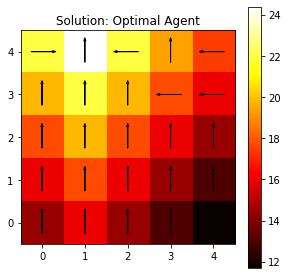

In [12]:
display_state_values(expected_values, title='Solution: Optimal Agent')

## Linear Programming Value Estimation
An exact solution, but extremely sensitive to formulation, hyperparameters, and unscaleable to anything but the simplest problems without making drastic simplifications/assumptions.

In [13]:
def solve_optimization(gamma=0.9, dim=5):
    solver = pywraplp.Solver('LinearProgrammingGridworld',
                             pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

    state_values = {s: solver.NumVar(-solver.infinity(), solver.infinity(), f'state_{s[0]}_{s[1]}')
                    for s in product(range(dim), range(dim))}
    objective = solver.Objective()
    objective.SetMinimization()
    environment = Gridworld()

    # Objective: minimize sum(v(s)) for all s
    for s0, v_s0 in state_values.items():
        objective.SetCoefficient(v_s0, 1)

        # Optimal: v(s) = max_a{r + gamma * v(s')}
        for a in Action:

            # Deterministically apply (s, a) to Gridworld to get (s', r)
            environment.set_state(s0)
            s1, r = environment.transition(a)            
            v_s1 = state_values[s1]

            # Constraint: v(s) - gamma * v(s') >= r
            constraint = solver.Constraint(r, solver.infinity())
            constraint.SetCoefficient(v_s0, 1)
            constraint.SetCoefficient(v_s1, -gamma)

    print(f'Number of variables={solver.NumVariables()}, constraints={solver.NumConstraints()}')
    solver.EnableOutput()
    status = solver.Solve() 
    if status == solver.OPTIMAL:
        values = np.zeros((5, 5))
        for (x, y), var in state_values.items():
            values[x, y] = var.solution_value()
        return values
    else:
        if status == solver.FEASIBLE:
            print('A potentially suboptimal solution was found.')
        else:
            print('The solver could not solve the problem.')    

Number of variables=25, constraints=100


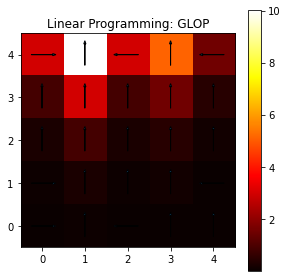

array([[ 3.00730776, 10.02435919,  3.00730776,  5.13874615,  1.54162384],
       [ 0.90219233,  3.00730776,  0.90219233,  1.54162384,  0.46248715],
       [ 0.2706577 ,  0.90219233,  0.2706577 ,  0.46248715,  0.13874615],
       [ 0.08119731,  0.2706577 ,  0.08119731,  0.13874615,  0.04162384],
       [ 0.02435919,  0.08119731,  0.02435919,  0.04162384,  0.01248715]])

In [14]:
# TODO: investigate feasability of gamma=0.9
glop_state_values = solve_optimization(gamma=0.3) 
display_state_values(glop_state_values, title='Linear Programming: GLOP')
glop_state_values

## Gradient Descent
Using gradient descent and a loss defined around the error between `v(s) - v*(s)` (big thanks to Gautam Kedia for cleaning up the loss function).

In [15]:
tf.config.experimental_run_functions_eagerly(True)


@tf.function
def get_problem(gamma, constraint_penalty, state_values=None, dim=5):
    # TODO: set better initial values
    if state_values == None:
        state_values = {s: tf.Variable(np.random.rand(), name=f'state_{s[0]}_{s[1]}', dtype=tf.float32)
                        for s in product(range(dim), range(dim))}

    errors = []
    environment = Gridworld()
    for s0, v_s0 in state_values.items():
        action_values = []
        for a in Action:       
            # Deterministically apply (s, a) to Gridworld to get (s', r)
            environment.set_state(s0)
            s1, r = environment.transition(a)            
            v_s1 = state_values[s1]

            action_value = r + gamma * v_s1
            action_values.append(action_value - v_s0)
        errors.append(tf.reduce_max(action_values))

    objective = tf.reduce_sum(tf.square(errors), name='objective')
    return objective, state_values


def plot_lp_state_values(state_values_dict, title=None):
    lp_values = np.zeros((5, 5))
    for (x, y), var in state_values_dict.items():
        lp_values[x, y] = var.numpy()
    display_state_values(lp_values, title=title)   
    return lp_values


def solve_gradients_tf(gamma=0.9, constraint_penalty=10.,
                          iterations=50000, stopping_delta=1e-4, log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1
    optimizer = tf.keras.optimizers.Adam()
    prev_loss_value = 1e9
    loss_history = []

    objective, state_values = get_problem(gamma=gamma, constraint_penalty=constraint_penalty)
    for i in range(1, iterations):
        with tf.GradientTape() as tape:    
            objective, state_values = get_problem(gamma=gamma, constraint_penalty=constraint_penalty, 
                                                  state_values=state_values)
            trainable_vars = list(state_values.values())
            loss = objective

        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))
        
        loss_value = loss.numpy()
        loss_history.append(loss_value)
        if i % log_frequency == 0:
            print(f'Iteration {i}: Loss={loss_value}')
            plot_lp_state_values(state_values, title=f'Iteration {i}')
            if abs(prev_loss_value - loss_value) < stopping_delta:
                break
            prev_loss_value = loss_value
    return state_values

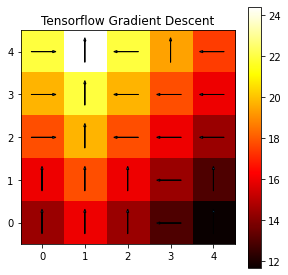

array([[21.9774704 , 24.41942787, 21.97747231, 19.41943741, 17.47750473],
       [19.77973557, 21.97749901, 19.77972603, 17.80176163, 16.02158356],
       [17.80177116, 19.77974129, 17.80177307, 16.02158546, 14.41943645],
       [16.021595  , 17.80175209, 16.02159882, 14.41943169, 12.97750187],
       [14.41943741, 16.02159309, 14.41943645, 12.97749424, 11.6797533 ]])

In [16]:
# Go get a coffee, this will take ~20 minutes
lp_state_values = solve_gradients_tf(gamma=0.9, stopping_delta=0.1)
plot_lp_state_values(lp_state_values, title='Tensorflow Gradient Descent')

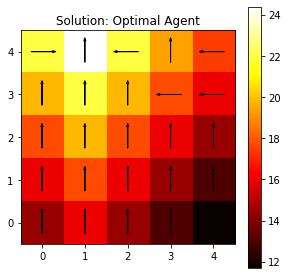

array([[22. , 24.4, 22. , 19.4, 17.5],
       [19.8, 22. , 19.8, 17.8, 16. ],
       [17.8, 19.8, 17.8, 16. , 14.4],
       [16. , 17.8, 16. , 14.4, 13. ],
       [14.4, 16. , 14.4, 13. , 11.7]])

In [17]:
# Expected (from textbook)
display_state_values(expected_values, title='Solution: Optimal Agent') 
expected_values

## Dynamic Programming: Value Iteration
Another strategy for finding the exact solution. This also requires a perfect understanding of the environment and not scaleable to complex problems. It also has weaker convergence guarantees than Linear Programming. Dynamic Programming can handle larger problems than Linear Programming, however the state-space grows exponentially and we must use other methods for the largest problems.

For this toy-problem, Value Iteration is extremely efficient, solving the optimal solution in ~200ms.

In [18]:
def value_iteration(gamma=0.9, epsilon=1e-4):
    state_values = np.random.randn(5, 5)
    dim = 5
    environment = Gridworld()

    delta = 1000
    while delta > epsilon:
        delta = 0
        for s0 in product(range(dim), range(dim)):
            v_s0 = state_values[s0]

            # Policy: arg-max action-value, having perfect information about the environment
            optimal_action_value = -1000
            for a in Action:   
                # Deterministically apply (s, a) to Gridworld
                environment.set_state(s0)
                s1, r = environment.transition(a)            
                v_s1 = state_values[s1]

                action_value = r + gamma * v_s1
                optimal_action_value = max(action_value, optimal_action_value)
            state_values[s0] = optimal_action_value
            delta += abs(v_s0 - optimal_action_value)

    return state_values
            

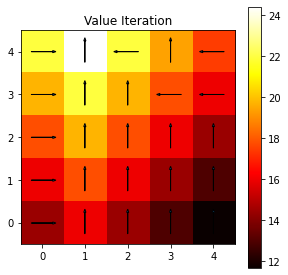

array([[21.97747655, 24.41942236, 21.97748013, 19.41942236, 17.47748013],
       [19.77972889, 21.97748013, 19.77973211, 17.8017589 , 16.02158301],
       [17.801756  , 19.77973211, 17.8017589 , 16.02158301, 14.41942471],
       [16.0215804 , 17.8017589 , 16.02158301, 14.41942471, 12.97748224],
       [14.41942236, 16.02158301, 14.41942471, 12.97748224, 11.67973402]])

In [19]:
vi_state_values = value_iteration()
display_state_values(vi_state_values, title='Value Iteration')
vi_state_values

## Monte Carlo
Monte Carlo is the first class of algorithm that is scaleable to complex real world problems. Unlike the previous approaches, Monte Carlo methods do not require a model of the environment, learning from both simulated episodes and actual experience. Additionally, this strategy does not require precise estimation of every state if only particular regions are relevant to our use-case.

However Monte Carlo requires a strategy for generating episodes, either for on-policy learning, off-policy learning, simulation, or back-test. None of the these algorithms generate sensible results in a reasonable amount of time without some form of exploration, such as epsilon-greedy policies. This is an extremely strong indication that a supervised learning approach would naively reach a suboptimal policy while never finding the data necessary to escape the local minima.

In [20]:
#  TODO: early stopping
def mc_prediction(every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    # GreedyAgent fails spectacularly here (likely supervised learning would also fail)
    agent = EpsilonGreedyAgent(name='First-Value MC Prediction')
    returns = {s: (0, 0) for s in product(range(dim), range(dim))}
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'MC Prediction: Iteration {i}')
        
        # Simulate episode
        s0 = (random.randint(0, 4), random.randint(0, 4))
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            a0 = agent.policy(s0)
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1]) 
            s0 = s1

        # Replay backwards from the end of the episode
        ret = 0
        j = T - 1
        episode_returns = {}
        while j > 0:
            r1 = episode[3*j + 3]
            s0 = episode[3*j - 1]
            j -= 1

            ret = r1 + gamma * ret
            episode_returns[s0] = ret
            if every_visit:
                mean_ret, c = returns[s0]
                returns[s0] = ((mean_ret * c + ret) / (c + 1), c + 1)
            
        # Update state values v(s)
        for s, ret in episode_returns.items():
            if not every_visit:
                mean_ret, c = returns[s]
                returns[s] = ((mean_ret * c + ret) / (c + 1), c + 1)
            agent.state_values[s] = returns[s][0]
    return agent

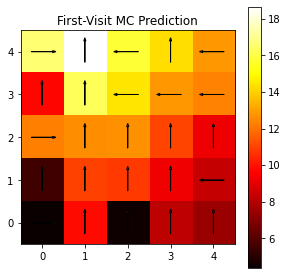

array([[16.59811779, 18.65415118, 15.7650856 , 14.3271649 , 12.81084875],
       [ 9.69305644, 16.28456813, 14.52791222, 12.8290061 , 12.37190864],
       [12.31548518, 12.59072867, 12.65410793, 11.06217442,  9.25474084],
       [ 5.53244647, 11.00768831, 10.8378179 ,  9.31963937,  8.37838535],
       [ 4.38531159,  9.80977127,  4.55191297,  8.1985443 ,  7.49547437]])

In [21]:
mcp_agent = mc_prediction(iterations=int(1e6), T=16)
display_state_values(mcp_agent.state_values, title='First-Visit MC Prediction')
mcp_agent.state_values

### Every Visit
Use every available example in the episode, instead of the earliest example only for each state. In other words, use more data to estimate state-value, even if the examples near the end of the episode are not very precise estimates.

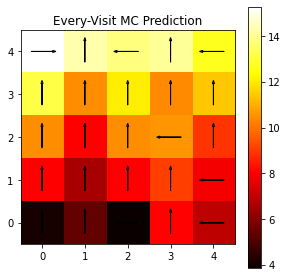

array([[15.29285228, 14.35392885, 13.80044226, 14.12532978, 12.74259688],
       [13.19360275, 10.43538015, 12.08522681, 10.43128891, 11.42321835],
       [10.43511279,  8.06759379, 10.43537114, 10.57236338,  8.93292497],
       [ 8.06717972,  6.59303376,  8.06737511,  9.13497975,  7.88737318],
       [ 4.12307495,  5.397982  ,  3.87702696,  8.08190304,  6.93893223]])

In [22]:
mcp_agent = mc_prediction(every_visit=True, iterations=int(1e6), T=16)
display_state_values(mcp_agent.state_values, title='Every-Visit MC Prediction')
mcp_agent.state_values

### Monte Carlo Control
This is the first example in our analysis that does not need an accurate model of the environment. Instead, we use our Agent to interact with the environment to generate new samples. In other words, we learn through affecting users, for better or worse, even if this means giving our users a terrible experience in the short term.

In [23]:
def mc_control(every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = LearnedAgent(name='MC Control', epsilon=0.01)  # this doesn't work without some exploration
    returns = {(x, y, a): (0, 0) for x, y, a in product(range(dim), range(dim), [a for a in Action])}
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.action_values.max(axis=2), title=f'MC Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        s0 = (x, y)
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1])             
            a0 = agent.policy(s1)

        # Replay backwards from the end of the episode
        ret = 0
        j = T - 1
        episode_returns = {}
        while j > 0:
            r1 = episode[3*j + 3]
            a0 = episode[3*j + 1]
            x0, y0 = episode[3*j - 1]
            key = (x0, y0, a0)
            j -= 1

            ret = r1 + gamma * ret
            episode_returns[key] = ret
            if every_visit:
                mean_ret, c = returns[key]
                returns[key] = ((mean_ret * c + ret) / (c + 1), c + 1)

        # Update action values q(s,a)
        for (x, y, a), ret in episode_returns.items():
            key = (x, y, a)
            if not every_visit:
                mean_ret, c = returns[key]
                returns[key] = ((mean_ret * c + ret) / (c + 1), c + 1)
            agent.action_values[(x, y, a.index)] = returns[key][0]

        # Update policy
        agent.policy_improvement()
    return agent

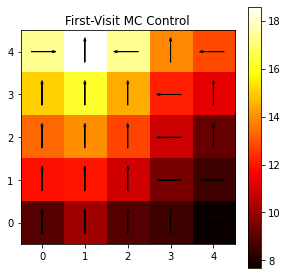

array([[17.37860763, 18.58333873, 17.36624539, 13.87999377, 12.84679615],
       [15.04118279, 16.32354844, 14.48183981, 12.18018702, 11.27720971],
       [13.37756686, 13.9606935 , 12.76420459, 10.86765588,  9.20169197],
       [11.91720796, 12.02166838, 10.89188658,  9.48738027,  8.55191662],
       [ 8.90432902, 10.14518961,  8.91110907,  8.55774002,  7.68603991]])

In [24]:
mcc_agent = mc_control(iterations=int(1e6), T=16)
display_state_values(mcc_agent.action_values.max(axis=2), title='First-Visit MC Control')
mcc_agent.action_values.max(axis=2)

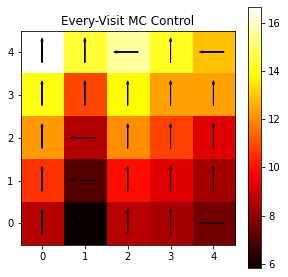

array([[16.64922907, 14.46044752, 15.55199386, 14.23936115, 12.89435035],
       [14.07057178, 10.91838087, 13.82750586, 12.36564767, 12.37060048],
       [12.28297224,  8.5584161 , 12.0771084 , 10.84519612,  9.33060119],
       [10.59719203,  7.04537248,  9.99209677,  9.30487053,  8.35758078],
       [ 8.64543264,  5.82082002,  8.61497582,  8.36412837,  7.53187641]])

In [25]:
mcc_agent = mc_control(every_visit=True, iterations=int(1e6), T=16)
display_state_values(mcc_agent.action_values.max(axis=2), title='Every-Visit MC Control')
mcc_agent.action_values.max(axis=2)

### Off-Policy Learning through Importance Sampling
Assuming our strategy for data collection obeys the *coverage* assumption (every state is visited at least once, such as by using a holdout or epsilon-greedy behavior policy), we can develop new agents without affecting users.

However this strategy can be very slow, especially if the behavior policy and target policy behave drastically differently, in which case most episodes will be thrown out by the target policy.

In [26]:
def get_policy_probs(agent, state, samples=100):
    probs = {a: 0 for a in Action}
    for _ in range(samples):
        a = agent.policy(state)
        probs[a] += 1 / samples
    return probs

# Importance Sampling
def off_policy_mc(behavior, target, gamma=0.9, 
                  dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    returns = {(x, y, a): (0, 0) for x, y, a in product(range(dim), range(dim), [a for a in Action])}
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(target.action_values.max(axis=2), title=f'Off-Policy MC: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        s0 = (x, y)
        environment.set_state(s0)
        episode = [s0]  # s0, a0, s1, r1, a1, s2, r2, a2, s3...
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            episode.extend([a0, s1, r1])             
            a0 = behavior.policy(s1)

        # Replay backwards from the end of the episode
        ret = 0
        j = T - 1
        w = 1
        while j > 0:
            r1 = episode[3*j + 3]
            a0 = episode[3*j + 1]
            x0, y0 = episode[3*j - 1]
            j -= 1

            key = (x0, y0, a0)
            ret = r1 + gamma * ret             
            mean_ret, c = returns[key]
            returns[key] = ((mean_ret + (w / (c + w)) * (ret - mean_ret)), c + w)
            
            # If the episode doesn't match the target policy, reject it
            target_action = target.policy((x0, y0))
            if target_action != a0:
                break
            w += get_policy_probs(behavior, (x0, y0))[a0]

        # Update policy
        for (x, y, a), ret in returns.items():
            target.action_values[(x, y, a.index)] = returns[(x, y, a)][0]
        target.policy_improvement()
    return target

This ones not quite right... 

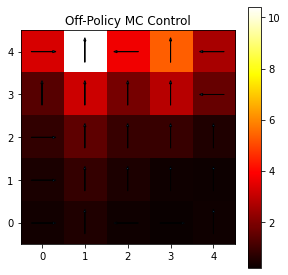

array([[ 3.3345636 , 10.40396285,  3.75525771,  5.39327382,  2.61793533],
       [ 1.40690717,  3.19151538,  1.88923299,  2.87071638,  1.64748373],
       [ 0.83770726,  1.51224628,  0.94221054,  0.92031191,  0.55352484],
       [ 0.50404036,  0.88254695,  0.52152918,  0.34324275,  0.27931181],
       [ 0.3705281 ,  0.56480438,  0.33564327,  0.22809774,  0.3455105 ]])

In [27]:
behavior_policy = EpsilonGreedyAgent(state_values=vi_state_values, epsilon=0.25)  # must obey assumption of coverage
target = LearnedAgent(name='Target Policy', epsilon=0)  # deterministic
off_policy_mc(behavior_policy, target, iterations=int(1e6), T=16)
display_state_values(target.action_values.max(axis=2), title='Off-Policy MC Control')
target.action_values.max(axis=2)

## Temporal-Difference Learning
Most of the previous examples have been instructive tools for comparison. Temporal-Difference (TD) is the core approach generating most RL learning algorithms by gradually updating our estimate towards our latest reward and value estimate scaled by a hyperparameter learning rate $\alpha$.

Unlike in Monte Carlo, we can apply these updates at every timestep, instead of waiting for the episode to terminate. For each update, we subtract the *difference* in our value estimate in *time*, before and after observation, from the current action value. While not as fast as Dynamic Programming (\~200ms), TD algorithms (\~1s) are still very performant and, more importantly, do not need a model of any complex environment characteristics.

Our analysis runs in parallel with the previous exploration into Monte Carlo. First we examine state-value prediction, then action-value control, and finally an off-policy algorithm using distinct behavior and target policies.

### Temporal Difference Prediction

In [28]:
def td_prediction(alpha, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = EpsilonGreedyAgent(name='TD Prediction')
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'TD Prediction: Iteration {i}')
        
        # Simulate episode
        s0 = (random.randint(0, 4), random.randint(0, 4))
        environment.set_state(s0)
        for _ in range(T):
            
            # Agent interacts with the environment
            a0 = agent.policy(s0)
            s1, r1 = environment.transition(a0)
            
            # Update state values v(s)
            v0 = agent.state_values[s0]
            v1 = agent.state_values[s1]
            agent.state_values[s0] = v0 + alpha * (r1 + gamma * v1 - v0)
            
            # Prep the next timestep
            s0 = s1
    return agent

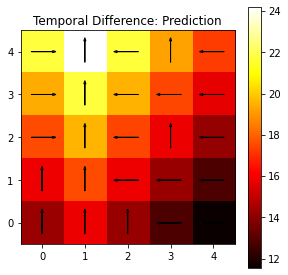

array([[21.76289759, 24.19960657, 21.70261083, 19.21161623, 17.32705086],
       [19.40996761, 21.76970875, 19.55468221, 17.52163441, 15.75049255],
       [17.62070587, 19.57785394, 17.464217  , 15.81896685, 14.21810365],
       [15.86534218, 17.6057003 , 15.85489386, 14.25181061, 12.8237065 ],
       [14.27692371, 15.8041699 , 14.27042004, 12.83299892, 11.55493771]])

In [29]:
tdp_agent = td_prediction(0.05, iterations=int(1e4), T=16)
display_state_values(tdp_agent.state_values, title='Temporal Difference: Prediction')
tdp_agent.state_values

### Temporal Difference Control (SARSA)

In [30]:
# SARSA
def td_control(alpha, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = LearnedAgent(name='TD Control', epsilon=0.01)  # this doesn't work without some exploration
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.action_values.max(axis=2), title=f'TD Control: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        sa0 = (x, y, a0.index)
        environment.set_state((x, y))
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            a1 = agent.policy(s1)
            
            sa1 = (s1[0], s1[1], a1.index)
            q0 = agent.action_values[sa0]
            q1 = agent.action_values[sa1]
            
            # On-Policy update, mid-episode
            agent.action_values[sa0] = q0 + alpha * (r1 + gamma * q1 - q0)
            agent.update_state_policy((sa0[0], sa0[1]))
            
            # Prep the next timestep            
            a0 = a1
            sa0 = sa1 

    return agent


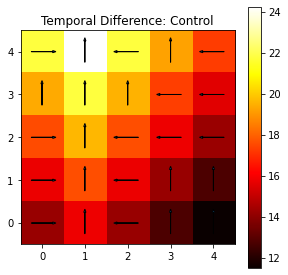

array([[21.79602179, 24.23310445, 21.79366064, 19.23723977, 17.32843087],
       [19.38020192, 21.78915462, 19.52503589, 17.35497744, 15.59616037],
       [17.62045702, 19.6191353 , 17.64940295, 15.86881807, 14.25016621],
       [15.82033153, 17.66232944, 15.82261551, 14.23187863, 12.80542116],
       [14.23531235, 15.88171919, 14.2183725 , 12.80351799, 11.5173044 ]])

In [31]:
tdc_agent = td_control(0.05, iterations=int(1e4), T=16)
display_state_values(tdc_agent.action_values.max(axis=2), title='Temporal Difference: Control')
tdc_agent.action_values.max(axis=2)

### Off-Policy Temporal Difference Control (Q-Learning)

In [39]:
def off_policy_td(behavior, target, alpha, gamma=0.9, 
                  dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(target.action_values.max(axis=2), title=f'Off-Policy TD: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        sa0 = (x, y, a0.index)
        environment.set_state((x, y))
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            
            # Evaluate using target policy
            a1 = target.policy(s1)            
            sa1 = (s1[0], s1[1], a1.index)
            q0 = target.action_values[sa0]
            q1 = target.action_values[sa1]
            
            # Off-Policy update, mid-episode
            target.action_values[sa0] = q0 + alpha * (r1 + gamma * q1 - q0)
            target.update_state_policy((sa0[0], sa0[1]))  # Off-Policy update, mid-episode
            
            # Generate the episode using the behavior policy          
            a0 = behavior.policy(s1)
            sa0 = (s1[0], s1[1], a0.index) 
            
    return target

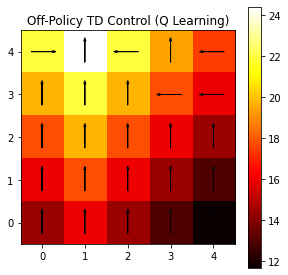

array([[21.97748529, 24.4194281 , 21.97748529, 19.4194281 , 17.47748529],
       [19.77973676, 21.97748529, 19.77973676, 17.80176308, 16.02158677],
       [17.80176308, 19.77973676, 17.80176308, 16.02158677, 14.4194281 ],
       [16.02158677, 17.80176308, 16.02158677, 14.4194281 , 12.97748529],
       [14.4194281 , 16.02158677, 14.4194281 , 12.97748529, 11.67973676]])

In [45]:
tdbp_agent = EpsilonGreedyAgent(state_values=vi_state_values, epsilon=0.25)  # must obey assumption of coverage
tdtp_agent = LearnedAgent(name='Target Policy', epsilon=0)  # deterministic
off_policy_td(tdbp_agent, tdtp_agent, 0.05, iterations=int(1e6), T=16)
display_state_values(tdtp_agent.action_values.max(axis=2), 
                     title='Off-Policy TD Control (Q Learning)', 
                     save_path='images/qlearning.png')
tdtp_agent.action_values.max(axis=2)

### Double-Q Learning
Random initial states with above average estimates induce bias in our target policy, or value *maximization bias*. To address *maximization bias*, we learn two distinct action values. At each timestep, we flip a coin and randomly use one agent to propose the next action while the other provides feedback. Then, both actors work together to select the best action.

This is similar to off-policy learning, however instead of committing behavior and target policies, we randomly swap the two policies reduce maximization bias in an on-policy setting.

In [34]:
class DoubleAgent(Agent):
    """Learn the Optimal Policy beginning with a random policy and no priors."""    
    def __init__(self, name='Double', gamma=0.9, dim=5, epsilon=0):
        super().__init__(name)
        self.policy_left = LearnedAgent('Left')
        self.policy_right = LearnedAgent('Right')
        self.action_values_right = np.random.randn(5, 5, 4)  # q(s, a)
        self.gamma = gamma
        self.epsilon = epsilon
        
    def policy(self, s, explore=True):
        if explore and random.random() < self.epsilon:
            return random.choice([a for a in Action])
        
        max_action_value = -1000
        for a in Action:
            key = (s[0], s[1], a.index)
            action_value_left = self.policy_left.action_values[key]
            action_value_right = self.policy_right.action_values[key]
            action_value = action_value_left + action_value_right
            if action_value > max_action_value:
                action = a
                max_action_value = action_value
        return action
    
    def plot_action_values(self, title):
        display_state_values(self.policy_left.action_values.max(axis=2), title=title + ' (Agent 1)')
        display_state_values(self.policy_right.action_values.max(axis=2), title=title + ' (Agent 2)')
        return self.policy_left.action_values.max(axis=2), self.policy_right.action_values.max(axis=2)


In [35]:
def double_q_learning(agent, alpha, gamma=0.9, 
                      dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            agent.plot_action_values(f'DQL: Iteration {i}')

        # Simulate episode from random (state, action)
        x, y, a0 = (random.randint(0, 4), random.randint(0, 4), random.choice([a for a in Action]))
        sa0 = (x, y, a0.index)
        environment.set_state((x, y))
        for _ in range(T):
            s1, r1 = environment.transition(a0)
            
            # Flip a coin
            if random.random() < 0.5:
                student, teacher = agent.policy_left, agent.policy_right
            else:
                student, teacher = agent.policy_right, agent.policy_left
                
            # Students picks the next action
            a1 = student.policy(s1)
            
            # Teacher provides feedback
            sa1 = (s1[0], s1[1], a1.index)
            q1 = teacher.action_values[sa1]
            
            # Update the student only
            q0 = student.action_values[sa0]
            student.action_values[sa0] = q0 + alpha * (r1 + gamma * q1 - q0)
            student.update_state_policy((sa0[0], sa0[1]))
            
            # Generate the episode using the combined policy (must obey assumption of coverage)
            a0 = agent.policy(s1)
            sa0 = (s1[0], s1[1], a0.index)                        
            
    return target

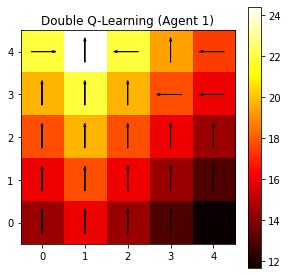

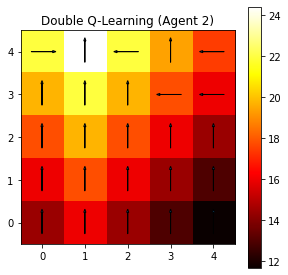

[[21.97748529 24.4194281  21.97748529 19.4194281  17.47748529]
 [19.77973676 21.97748529 19.77973676 17.80176308 16.02158677]
 [17.80176308 19.77973676 17.80176308 16.02158677 14.4194281 ]
 [16.02158677 17.80176308 16.02158677 14.4194281  12.97748529]
 [14.4194281  16.02158677 14.4194281  12.97748529 11.67973676]]

[[21.97748529 24.4194281  21.97748529 19.4194281  17.47748529]
 [19.77973676 21.97748529 19.77973676 17.80176308 16.02158677]
 [17.80176308 19.77973676 17.80176308 16.02158677 14.4194281 ]
 [16.02158677 17.80176308 16.02158677 14.4194281  12.97748529]
 [14.4194281  16.02158677 14.4194281  12.97748529 11.67973676]]


In [36]:
dqll_agent = DoubleAgent(name='DQL Agent', epsilon=0.05)  # must explore
double_q_learning(dqll_agent, 0.05, iterations=int(1e5), T=16)
q1, q2 = dqll_agent.plot_action_values('Double Q-Learning')
print(q1)
print()
print(q2)

## N-Step
Maintaining a longer window for updates than TD-Learning, beginning to resemble a strategy closer to Monte Carlo. Sutton & Barto claim N-Step return has an *error reduction property* with gauaranteed worst case to be better than $V_{t+n-1}$.

In [72]:
import collections


def ntd_prediction(alpha, n, every_visit=False, gamma=0.9, dim=5, T=32, iterations=int(1e4), log_frequency=None):
    if log_frequency is None:
        log_frequency = iterations + 1

    agent = EpsilonGreedyAgent(name='N-Step TD Prediction')
    environment = Gridworld()
    for i in range(1, iterations):
        if i % log_frequency == 0:
            display_state_values(agent.state_values, title=f'N-Step TD Prediction: Iteration {i}')
        
        # Simulate episode
        s0 = (random.randint(0, 4), random.randint(0, 4))
        environment.set_state(s0)
        
        states = collections.deque()
        states.append(s0)
        rewards = [0] * n
        
        for i in range(1, T + n):
            # Episode generation
            if i < T:
                # Agent interacts with the environment
                a0 = agent.policy(s0)
                s1, r1 = environment.transition(a0)                
                states.append(s1)
                rewards[i % n] = r1
            else:  # Episode over, update only
                rewards[i % n] = 0
                
            # Update state value
            if i >= n:           
                target = 0  # gain i-n:i
                s_i = states[-1]  # latest observation  
                if s_i:
                    target += agent.state_values[s_i]
                for j in range(0, n):
                    target = rewards[(i - j) % n] + gamma * target
                
                s0 = states.popleft()
                v0 = agent.state_values[s0]
                agent.state_values[s0] = v0 + alpha * (target - v0)
            
            # Prep the next timestep
            s0 = states[-1] if states else None
    return agent

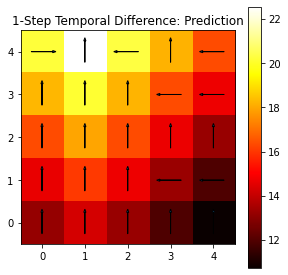

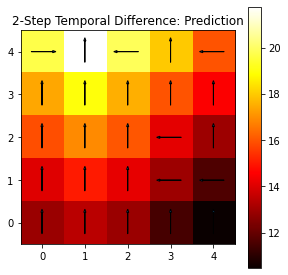

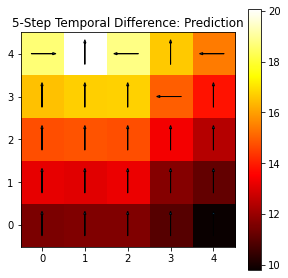

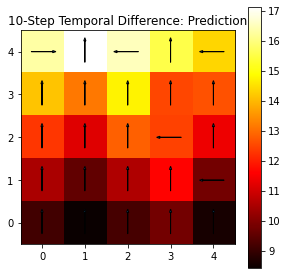

In [75]:
for i in [1,2,5,10]:
    ntdp_agent = ntd_prediction(0.01, i, iterations=int(1e5), T=16)
    display_state_values(ntdp_agent.state_values, title=f'{i}-Step Temporal Difference: Prediction')

## Conclusion
In this notebook, we have intestigated 4 types of algorithms, **Linear Programming (LP)**, **Dynamic Programming (DP)**, **Monte Carlo (MC)**, and **Temporal Difference Learning (TD)** in our toy Gridworld environment. For the most part, all of these algorithms were able to solve our problem optimally. However **LP** and **DP** require exact models of the environment, making them difficult to use in complex problems. They both also scale poorly with large problems. Neither **MC** nor **TD** require these models, making them both more suitable to complex, real-world scenarios.

For **MC** and **TD**, we divided the problem into 3 aspects, **Prediction** (evaluating the returns for a policy), **On-Policy Control** (using our policy on the environment to improve itself) and **Off-Policy Control** (learning while another policy is in control). We also explore a generalization of **TD**, **N-Step TD**, which extends the update window and begins to resemble the longer horizon estimates used in **MC**.